# Gaussian Mixture Model Example

In [3]:
# Imports
from pathlib import Path

import jax
import jax.numpy as jnp
import jax.random as random
import numpy as np
import numpyro.distributions as dist
import ot
import pandas as pd
from jax import grad, vmap
from jax.tree_util import Partial
from jaxtyping import Array

import diffusionlib.sde.jax as sde_lib
from diffusionlib.config_definition.task import TaskConfig
from diffusionlib.sampler.jax import get_cs_sampler, get_ddim_chain
from diffusionlib.util.misc import get_linear_beta_function, get_sampler, get_sigma_function
from diffusionlib.util.plot import plot_image, plot_single_image

DDIM_METHODS = ('pigdmvp', 'pigdmve', 'ddimve', 'ddimvp', 'kgdmvp', 'kgdmve', 'stsl')

From the [MCGDiff paper](https://arxiv.org/pdf/2308.07983.pdf) (page 5), the marginals of the
forward process are available in closed form, meaning we don't need a trained model to
estimate the score or noise ($\epsilon$).

In [4]:
# Define score and epsilon functions
def get_score_fn(ou_dist, sde):
    return vmap(grad(lambda x, t: ou_dist(sde.mean_coeff(t)).log_prob(x)))


# NOTE: model/epsilon function is just the negative score by the variance
def get_model_fn(ou_dist, sde):
    return vmap(
        grad(lambda x, t: -jnp.sqrt(sde.variance(t)) * ou_dist(sde.mean_coeff(t)).log_prob(x))
    )

In [5]:
# Define posterior
def gaussian_posterior(
    y: Array,
    likelihood_a: Array,
    likelihood_bias: Array,
    likelihood_precision: Array,
    prior_loc: Array,
    prior_covar: Array,
) -> dist.MultivariateNormal:
    # Compute the precision matrix of the prior distribution
    prior_precision_matrix = jnp.linalg.inv(prior_covar)

    # Calculate the precision matrix of the posterior distribution
    posterior_precision_matrix = (
        prior_precision_matrix + likelihood_a.T @ likelihood_precision @ likelihood_a
    )

    # Calculate the covariance matrix of the posterior distribution
    posterior_covariance_matrix = jnp.linalg.inv(posterior_precision_matrix)

    # Calculate the mean of the posterior distribution
    posterior_mean = posterior_covariance_matrix @ (
        likelihood_a.T @ likelihood_precision @ (y - likelihood_bias)
        + prior_precision_matrix @ prior_loc
    )

    # Ensure symmetry and numerical stability of the covariance matrix
    # Handle potential numerical issues by regularization
    try:
        posterior_covariance_matrix = (
            posterior_covariance_matrix + posterior_covariance_matrix.T
        ) / 2
    except ValueError:
        u, s, v = jnp.linalg.svd(posterior_covariance_matrix, full_matrices=False)
        s = jnp.clip(s, 1e-12, 1e6).real
        posterior_covariance_matrix = u.real @ jnp.diag(s) @ v.real
        posterior_covariance_matrix = (
            posterior_covariance_matrix + posterior_covariance_matrix.T
        ) / 2

    return dist.MultivariateNormal(
        loc=posterior_mean, covariance_matrix=posterior_covariance_matrix
    )

In [6]:
# Define mixture model function
def ou_mixt(mean_coeff: float, means: Array, dim: int, weights: Array) -> dist.MixtureSameFamily:
    means = jnp.vstack(means) * mean_coeff
    covs = jnp.repeat(jnp.eye(dim)[None], axis=0, repeats=means.shape[0])
    return dist.MixtureSameFamily(
        component_distribution=dist.MultivariateNormal(loc=means, covariance_matrix=covs),
        mixing_distribution=dist.CategoricalProbs(weights),
    )

In [7]:
# Define posterior for the mixture model
def get_posterior(
    obs: Array, prior: dist.MixtureSameFamily, a: Array, sigma_y: Array
) -> dist.MixtureSameFamily:
    mixing_dist: dist.CategoricalProbs = prior.mixing_distribution
    component_dist: dist.MultivariateNormal = prior.component_distribution  # type: ignore
    comp_mean = component_dist.mean
    comp_cov: Array = component_dist.covariance_matrix  # type: ignore

    # Precompute the inverse of the observation noise covariance matrix
    precision = jnp.linalg.inv(sigma_y)
    modified_means = []
    modified_covars = []
    weights = []

    # Iterate through the components of the prior distribution
    for loc, cov, weight in zip(comp_mean, comp_cov, mixing_dist.probs):
        # Compute the posterior distribution for the current component
        new_dist = gaussian_posterior(obs, a, jnp.zeros_like(obs), precision, loc, cov)
        modified_means.append(new_dist.mean)
        modified_covars.append(new_dist.covariance_matrix)

        # Calculate the prior likelihood and residual
        prior_x = dist.MultivariateNormal(loc, covariance_matrix=cov)
        residue = obs - a @ new_dist.loc

        # Compute log-probability contributions
        log_constant = (
            -0.5 * residue @ precision @ residue.T
            + prior_x.log_prob(new_dist.mean)
            - new_dist.log_prob(new_dist.mean)
        )

        # Compute the log weight for the component
        weights.append(jnp.log(weight) + log_constant)

    # Normalize weights
    weights = jnp.array(weights)
    normalized_weights = weights - jax.scipy.special.logsumexp(weights)

    # Construct categorical distribution from the normalized weights
    categorical_distribution = dist.CategoricalLogits(logits=normalized_weights)

    # Construct a mixture distribution of multivariate normals
    multivariate_mixture = dist.MultivariateNormal(
        loc=jnp.stack(modified_means, axis=0),
        covariance_matrix=jnp.stack(modified_covars, axis=0),
    )

    return dist.MixtureSameFamily(categorical_distribution, multivariate_mixture)

In [8]:
def extended_svd(a: Array):
    # Compute the singular value decomposition
    u, s, v = jnp.linalg.svd(a, full_matrices=True)

    # Create a coordinate mask based on the length of the singular values
    coordinate_mask = jnp.ones_like(v[0])
    coordinate_objects = jnp.zeros((v.shape[0] - len(s),))
    coordinate_mask = jnp.concatenate([coordinate_mask[: len(s)], coordinate_objects])

    return u, s, v, coordinate_mask

In [9]:
def generate_measurement_equations(dim, dim_y, mixt, noise_std, key):
    # Generate random keys for different sources of randomness
    key_a, key_diag, key_init_sample, key_init_obs = random.split(key, 4)

    # Create random matrix
    a = random.normal(key_a, (dim_y, dim))

    # Build extended SVD
    u, s, v, coordinate_mask = extended_svd(a)

    # Re-create `s` using uniform sampling, sorting the generated values to align with
    # properties of singular values being ordered in the SVD Sigma (`s`) matrix
    s_new = jnp.sort(random.uniform(key_diag, s.shape), descending=True)
    s_new_mat = jnp.diag(s_new)

    # Re-construct `a` using the sorted diag and coordinate mask
    a_recon = u @ (s_new_mat @ v[coordinate_mask == 1, :])

    # Sample initial data and simulate initial observations
    init_sample = mixt.sample(key_init_sample)
    init_obs = a_recon @ init_sample
    init_obs += random.normal(key_init_obs, init_obs.shape) * noise_std

    # Construct observation noise covariance matrix
    sigma_y = jnp.diag(jnp.full(s.shape, noise_std**2))

    # Calculate posterior
    posterior = get_posterior(init_obs, mixt, a_recon, sigma_y)

    return a_recon, sigma_y, u, s_new, v, coordinate_mask, posterior, init_obs

In [10]:
# Setup
config = TaskConfig.load()

batch_size = config.eval.batch_size
dim = config.data.image_size

jax.default_device = jax.devices()[0]
key = random.PRNGKey(config.seed)
color_posterior = "#a2c4c9"
color_algorithm = "#ff7878"

dists_infos = []
ind_dim = 0
ind_increase = 0
size = 8.0

In [11]:
# Setup SDE
if config.training.sde.lower() == "vpsde":
    beta, log_mean_coeff = get_linear_beta_function(config.model.beta_min, config.model.beta_max)
    sde = sde_lib.VP(beta, log_mean_coeff)
elif config.training.sde.lower() == "vesde":
    sigma = get_sigma_function(config.model.sigma_min, config.model.sigma_max)
    sde = sde_lib.VE(sigma)
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")

In [12]:
# Setup inverse problem
means = [jnp.array([-size * i, -size * j] * (dim // 2)) for i in range(-2, 3) for j in range(-2, 3)]
weights = jnp.ones(len(means))
weights = weights / weights.sum()

ou_mixt_fun = Partial(ou_mixt, means=means, dim=dim, weights=weights)
mixt = ou_mixt_fun(1)

In [13]:
# Get prior samples
score = get_score_fn(ou_mixt_fun, sde)
model = get_model_fn(ou_mixt_fun, sde)

sampler = get_sampler(
    shape=(batch_size, dim),
    outer_solver=get_ddim_chain(config, model),  # OR get_markov_chain(config, score)
    inner_solver=None,
    denoise=config.sampling.denoise,
)

key, sub_key = random.split(key)
samples, nfe = sampler(sub_key)

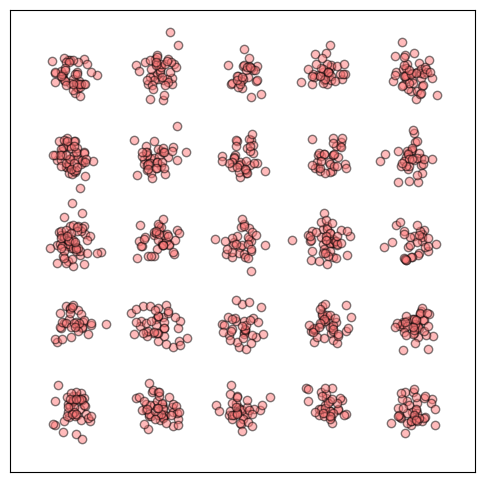

In [14]:
# Plot prior samples
plot_single_image([0, 1], samples, color=color_algorithm)

In [15]:
key, sub_key = random.split(key)
dim_y = 1

(
    a,
    sigma_y,
    u,
    diag,
    v,
    coordinate_mask,
    posterior,
    init_obs,
) = generate_measurement_equations(dim, dim_y, mixt, config.sampling.noise_std, sub_key)

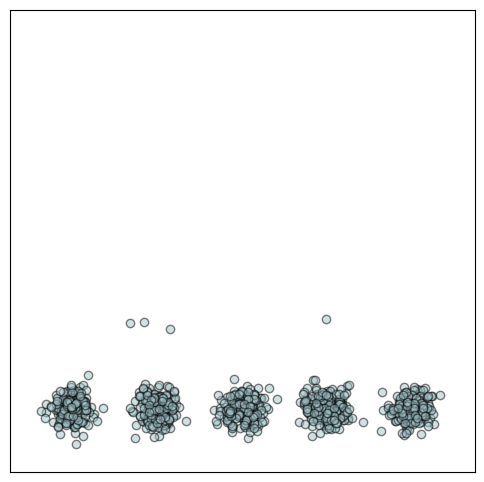

In [16]:
# Get posterior samples (using NUTS)
key, sub_key = random.split(key)
posterior_samples = posterior.sample(sub_key, (batch_size,))
plot_single_image(
    [0, 1],
    posterior_samples,
    color=color_posterior,
)

In [17]:
y = jnp.tile(init_obs, (batch_size, 1))
h = jnp.array(a, dtype=jnp.float32)

def observation_map(x):
    x = x.flatten()
    return h @ x


def adjoint_observation_map(y):
    y = y.flatten()
    return h.T @ y

In [18]:
cs_method = config.sampling.cs_method
fn = model if cs_method in DDIM_METHODS else score
sampler = get_cs_sampler(
    config,
    cs_method,
    sde,
    fn,
    (batch_size, dim),
    None,  # dataset.get_data_inverse_scaler(config),
    y,
    h,
    observation_map,
    adjoint_observation_map,
    stack_samples=False,
)

In [19]:
key, sub_key = random.split(key)
samples, _ = sampler(sub_key)
samples = samples.reshape(batch_size, dim)

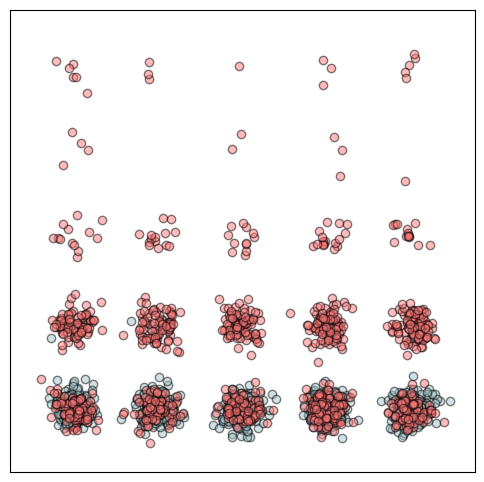

In [30]:
plot_image([0, 1], samples, posterior_samples)

In [25]:
ot_sliced_wasserstein_distance = ot.sliced_wasserstein_distance(
    np.array(posterior_samples),
    np.array(samples),
    n_projections=10_000,
)
print(ot_sliced_wasserstein_distance)

4.931868544798878
